In [1654]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from statsmodels.stats.diagnostic import het_white
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [1655]:
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [1656]:
car = pd.read_csv('CarPrice_Assignment.csv')
car.drop('car_ID',axis=1,inplace=True)

In [1657]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

In [1658]:
car['CarName'] = car.apply(lambda x: x['CarName'].split(' ')[0].lower(),axis=1)

In [1659]:
correct_name = {'maxda':'mazda','porcshce':'porsche','toyouta':'toyota','vokswagen':'volkswagen','vw':'volkswagen'}
car['CarName'] = car.apply(lambda x: correct_name[x['CarName']] if x['CarName'] in correct_name else x['CarName'],axis=1)

In [1660]:
car.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [1661]:
car.describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


### Exploratory Data Analysis

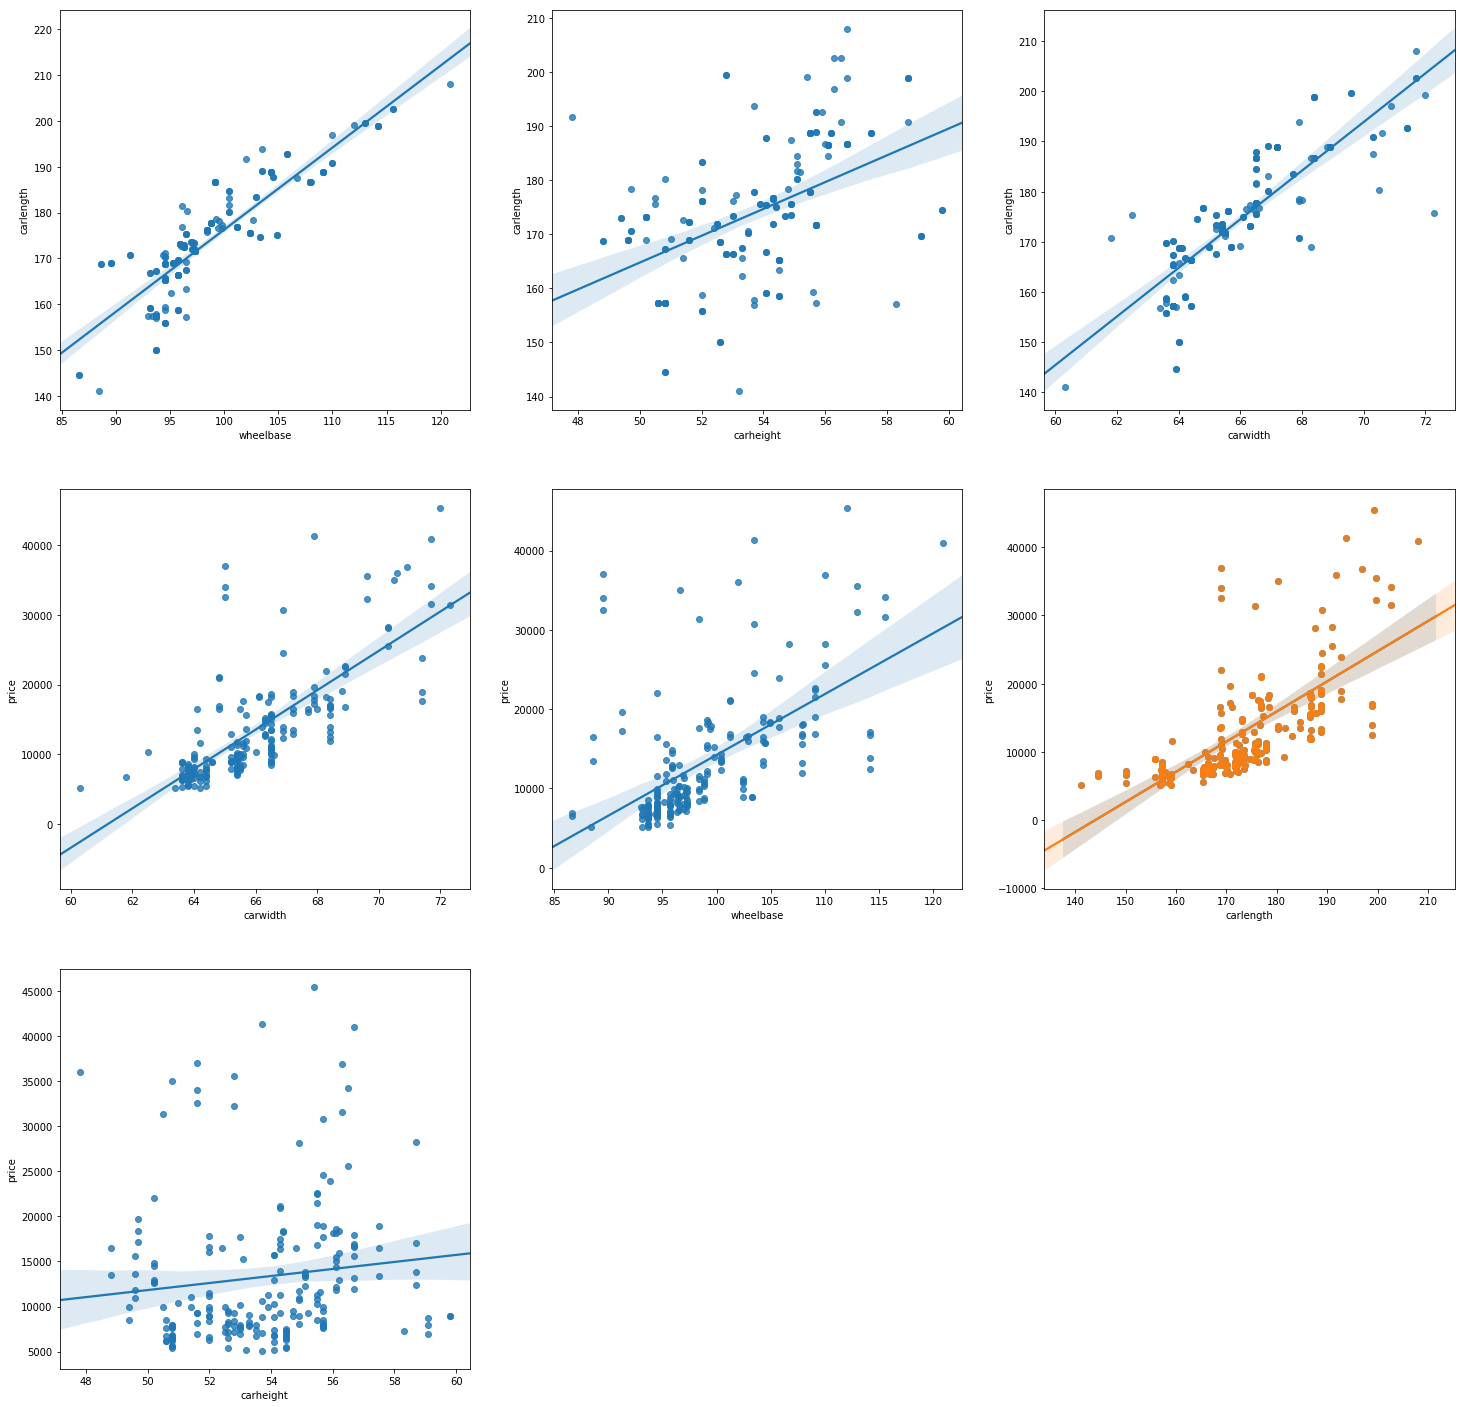

In [1662]:
plt.figure(figsize=(25,25))
plt.subplot(3,3,1)
sns.regplot(x='wheelbase',y='carlength',data=car)
plt.subplot(3,3,2)
sns.regplot(x='carheight',y='carlength',data=car)
plt.subplot(3,3,3)
sns.regplot(x='carwidth',y='carlength',data=car)
plt.subplot(3,3,4)
sns.regplot(x='carwidth',y='price',data=car)
plt.subplot(3,3,5)
sns.regplot(x='wheelbase',y='price',data=car)
plt.subplot(3,3,6)
sns.regplot(x='carlength',y='price',data=car)
plt.subplot(3,3,6)
sns.regplot(x='carlength',y='price',data=car)
plt.subplot(3,3,7)
sns.regplot(x='carheight',y='price',data=car)


* We see that both wheelbase,carheight and  carwidth are highly correlated with carlength. 
* Carwidth and wheel base shows a linear correlation with price, but the variance is not constant.
* Carlength shows a somewhat non-linear trend and large number of values are far away from the line.
* Carheight shows no linearity with price

#### Here we introduce a new variable volume defined as the product of the length, wheelbase and height.

There are two reasons for the introduction:
1. It summarises the three variables into one actionables one
2. It shows a more positive correlation with price

#### Another variable introduced is the ratio of length to width

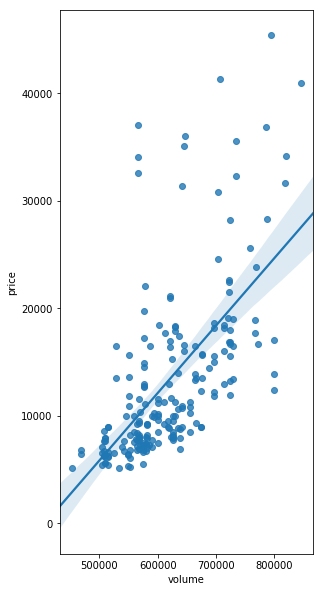

In [1663]:
car['volume'] = car['carlength']*car['carwidth']*car['carheight']
car['length:width'] = car['carlength']/car['carwidth']
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
sns.regplot(x='volume',y='price',data=car)

We can see the derived variable volume shows a pretty strong positive correlation with price as expected

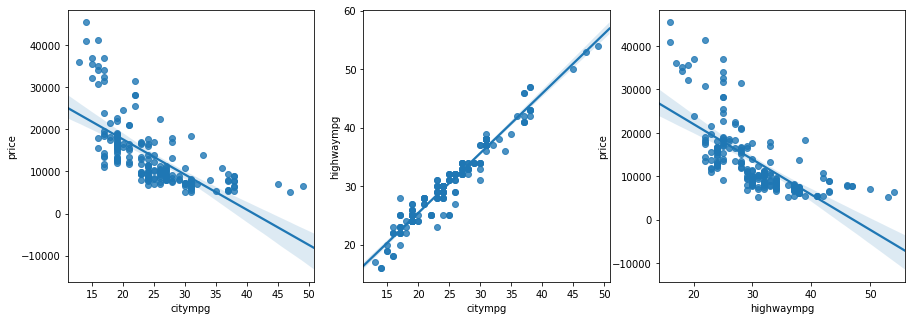

In [1664]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.regplot(x='citympg',y='price',data=car)
plt.subplot(1,3,2)
sns.regplot(x='citympg',y='highwaympg',data=car)
plt.subplot(1,3,3)
sns.regplot(x='highwaympg',y='price',data=car)

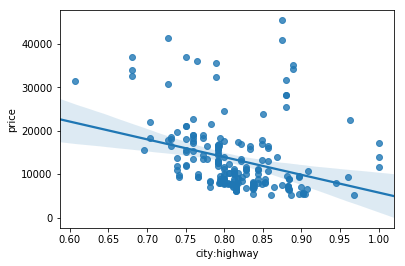

In [1665]:
car['city:highway'] = car['citympg']/car['highwaympg']
sns.regplot(x='city:highway',y='price',data=car)

* We see high collinearity between citympg and highwaympg.
* Both display a negative relation to price, depecting the fact that high speed vehicles usually have higher price and lower millage.
#### We introduce a  new variable city:highway defined as the ratio of citympg and highwaympg
* One important aspect that buyers see while buying a car is ratio of city and highway millage. We see price shows a positive relation with the ratio

In [1666]:
cyl_num = {'eight':8, 'five':5, 'four':4, 'six':6, 'three':3, 'twelve':12, 'two':2}
car['cylindernumber'] = car.apply(lambda x: cyl_num[x['cylindernumber']],axis=1)

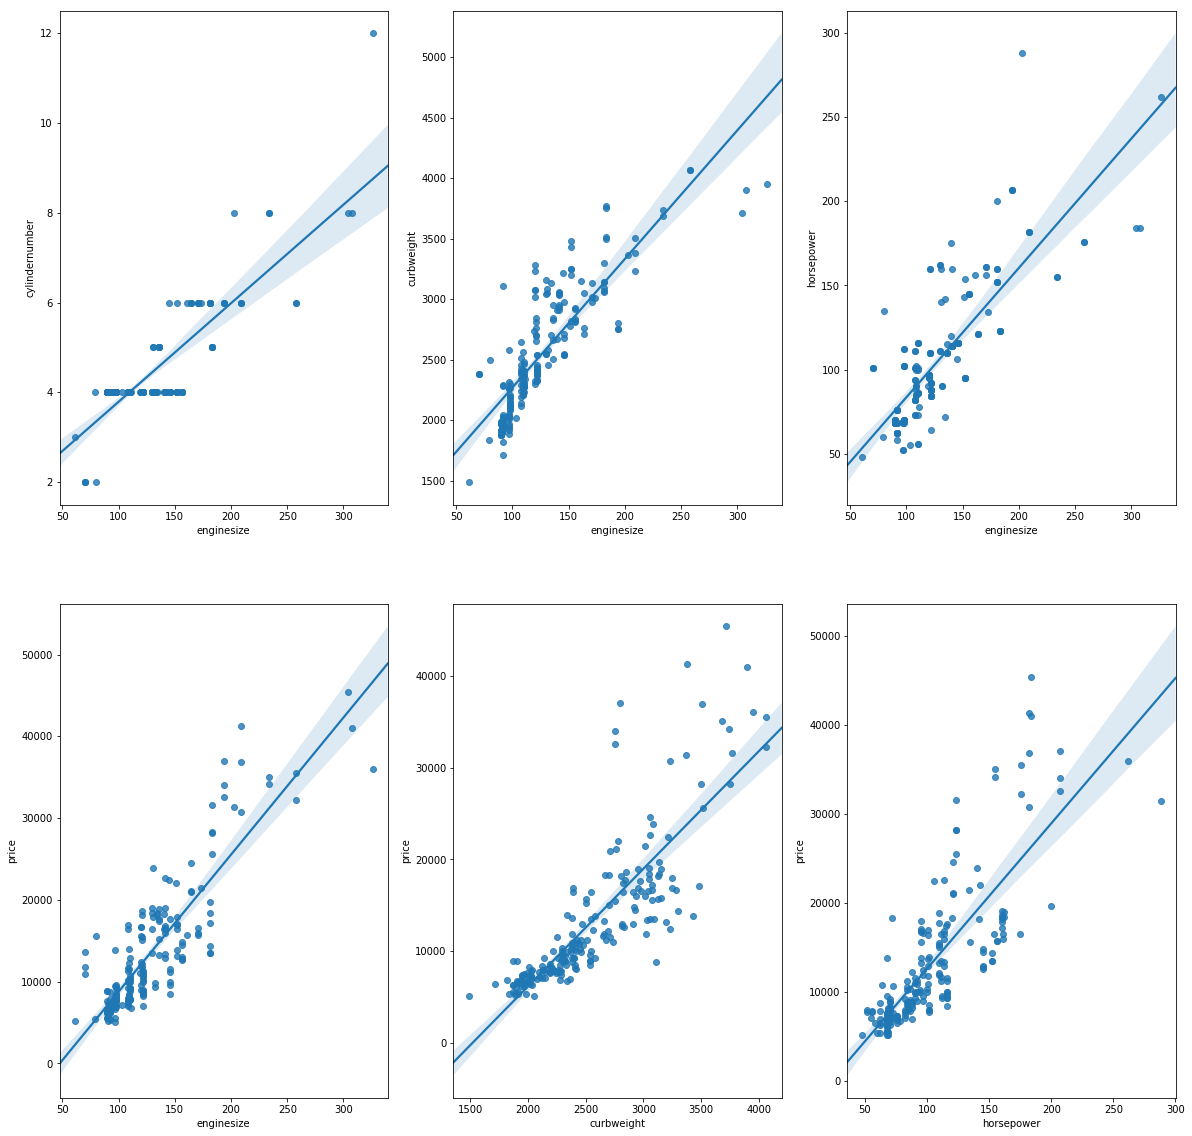

In [1667]:
plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
sns.regplot(x='enginesize',y='cylindernumber',data=car)
plt.subplot(2,3,2)
sns.regplot(x='enginesize',y='curbweight',data=car)
plt.subplot(2,3,3)
sns.regplot(x='enginesize',y='horsepower',data=car)
plt.subplot(2,3,4)
sns.regplot(x='enginesize',y='price',data=car)
plt.subplot(2,3,5)
sns.regplot(x='curbweight',y='price',data=car)
plt.subplot(2,3,6)
sns.regplot(x='horsepower',y='price',data=car)

#### Here we introduce 4 new variables from engineering point of view:
* engine:curbweight is the ratio of enginesize to curbweight. Engines are generally a major contributing component to the curb weight and the weight of engine is directly proportional to the size. So, balacing this ratio will lead to a better balance between the two.
* hp:peakrpm : horsepower denotes the power produced by the engine, while peakrpm denotes the maximum rpm. So, this ratio denotes the peak torque produced by the engine.
* enginesize:cylnum : Number and size of cylinders are the most major factor influencing the size of an engine. So, diving enginesize by cylnum gives a factor which is proportional to cylinder size.
* enginesize:hp : Higher engine size implies higher horse power. The main factor is the cylinder size, but this ratio gives a indicating factor of enginesize utilisation

In [1668]:
car['engine:curb_weight'] = car['enginesize']/car['curbweight']
car['hp:peakrpm'] = car['horsepower']/car['peakrpm']
car['enginesize:cylnum'] = car['enginesize']/car['cylindernumber']
car['enginesize:hp'] = car['enginesize']/car['horsepower']

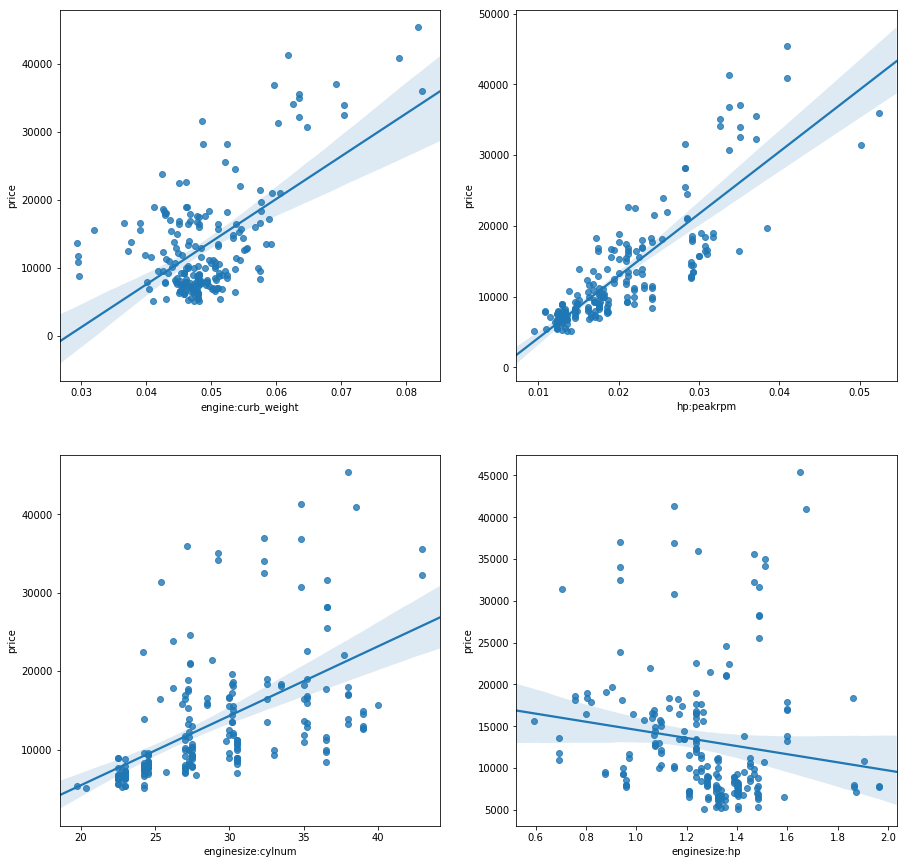

In [1669]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.regplot(y='price',x='engine:curb_weight',data=car)
plt.subplot(2,2,2)
sns.regplot(y='price',x='hp:peakrpm',data=car)
plt.subplot(2,2,3)
sns.regplot(y='price',x='enginesize:cylnum',data=car)
plt.subplot(2,2,4)
sns.regplot(y='price',x='enginesize:hp',data=car)

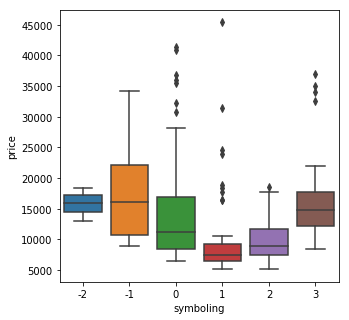

In [1670]:
plt.figure(figsize=(5,5))
sns.boxplot(x='symboling',y='price',data=car)

We can see that a u shaped curve across the different categories, with 1 having lowest price,  3 and -2 on either end having high prices 

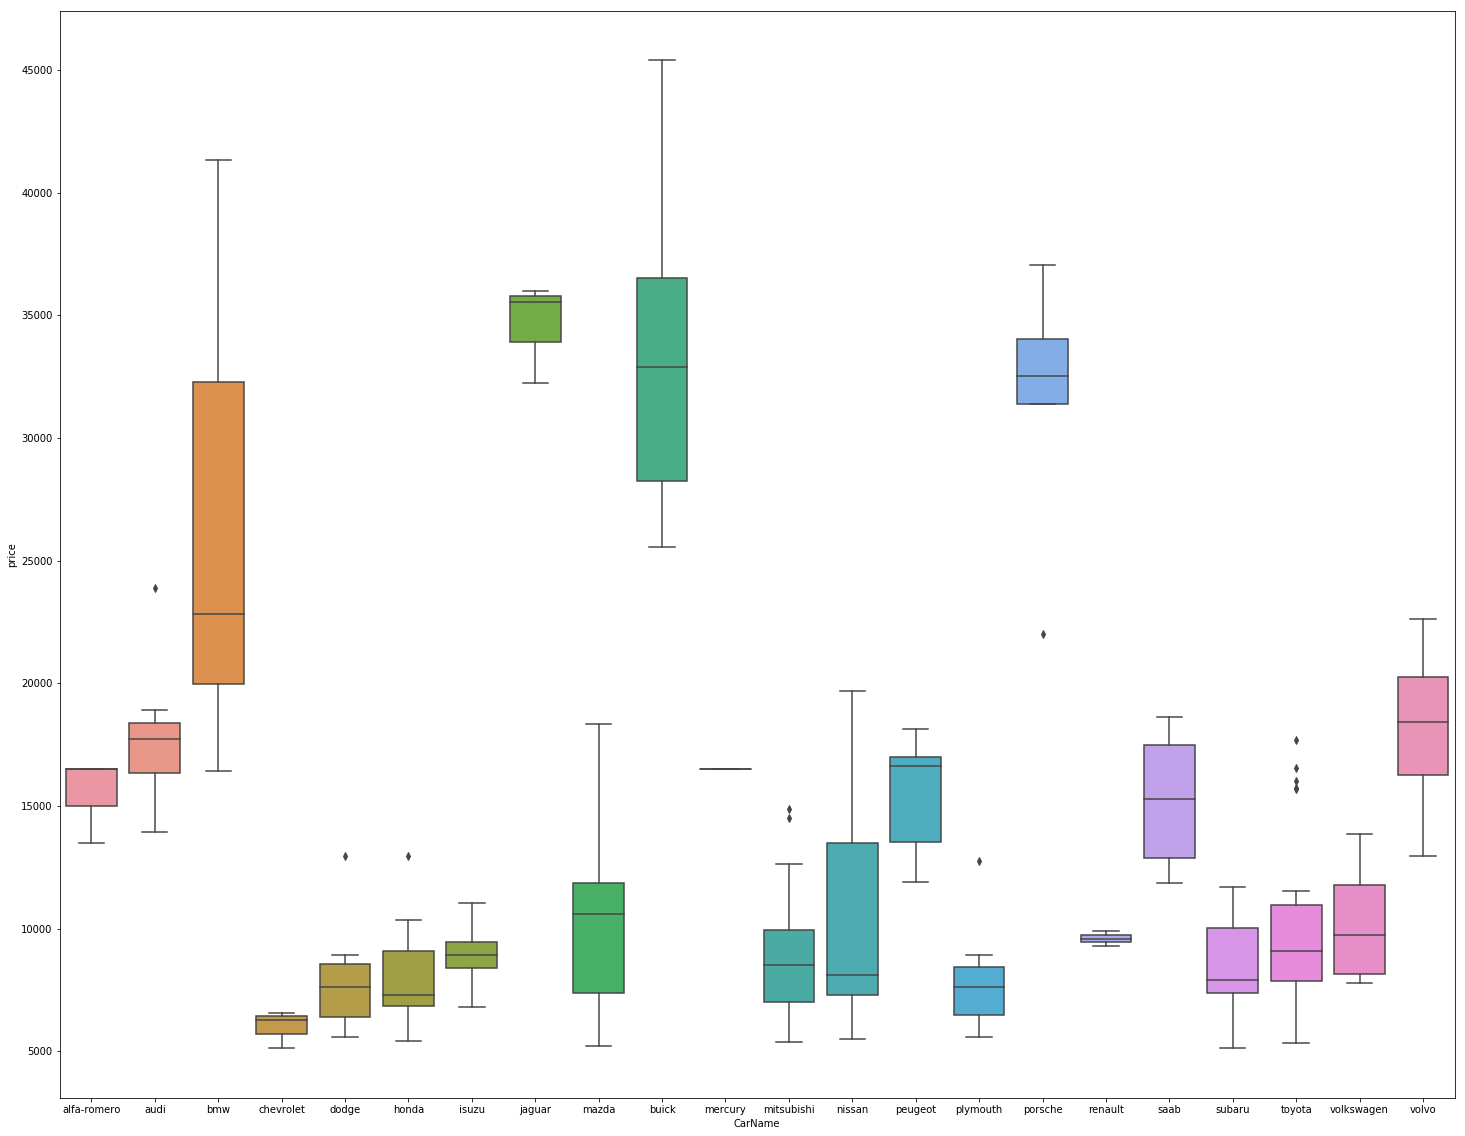

In [1671]:
plt.figure(figsize=(25,20))
sns.boxplot(x='CarName',y='price',data=car)

We see that a very distinct banding can be seen across various prices for groups of car companies.
* We can define the three categories low (0-10000),mid(10000-20000) and high(>20000)

In [1672]:
car['price_cat'] = car.apply(lambda x: 'low' if x['price']<=10000 else ('mid' if x['price']<=20000 else 'high'),axis=1)

In [1673]:
car.groupby(['price_cat','CarName'])['CarName'].count()

price_cat  CarName    
high       audi            1
           bmw             6
           buick           8
           jaguar          3
           porsche         5
           volvo           3
low        chevrolet       3
           dodge           8
           honda          10
           isuzu           3
           mazda           7
           mitsubishi     10
           nissan         12
           plymouth        6
           renault         2
           subaru          9
           toyota         22
           volkswagen      8
mid        alfa-romero     3
           audi            6
           bmw             2
           dodge           1
           honda           3
           isuzu           1
           mazda          10
           mercury         1
           mitsubishi      3
           nissan          6
           peugeot        11
           plymouth        1
           saab            6
           subaru          3
           toyota         10
           volkswage

We see that most car's are in low and mid range, indicating both a high market and high competition. While high end car market has only six players. This serves as key deciding factor in which segment to launch a car in.

Now, although company name might appear to be a KPI, but for the company main information required is not companywise price trend but segmentwise competiton and market as seen above.

Thereform for our further analysis including company is of no use because our main target is identifying key drivers of price.

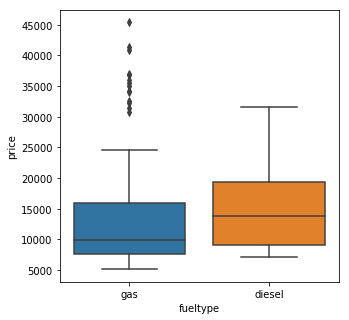

In [1674]:
plt.figure(figsize=(5,5))
sns.boxplot(x='fueltype',y='price',data=car)

We see that fueltype is not a high differentiator of price , because gas disel prices are highly overlapped. Although, the median value of diesel cars are higher, gas has some very costly cars as well.

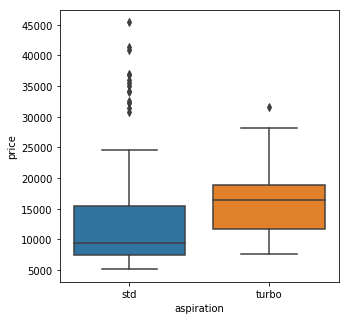

In [1675]:
plt.figure(figsize=(5,5))
sns.boxplot(x='aspiration',y='price',data=car)

Now, here we see a significant difference between turbo and standard aspiration, with the median of turbo being higher than standard upper quartile.

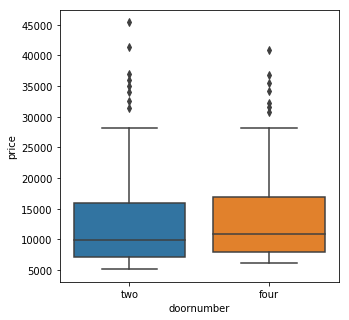

In [1676]:
plt.figure(figsize=(5,5))
sns.boxplot(x='doornumber',y='price',data=car)

We see that no differentiation of price between two and four doors car.

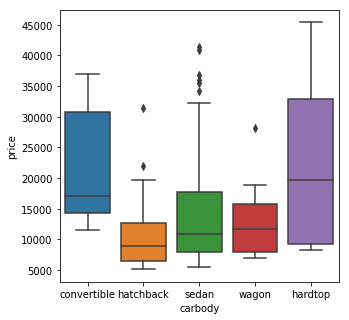

In [1677]:
plt.figure(figsize=(5,5))
sns.boxplot(x='carbody',y='price',data=car)

We see that convertibles and hardtops have much higher price than hatchback,sedan and wagon. So,this is a good differentiator of price.

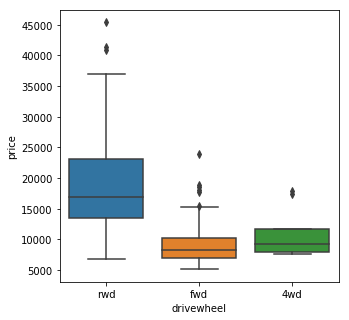

In [1678]:
plt.figure(figsize=(5,5))
sns.boxplot(x='drivewheel',y='price',data=car)

Again a very clear differentiation of price, rear wheel drive vehicles are much costlier than front wheel or four wheel drive ones.

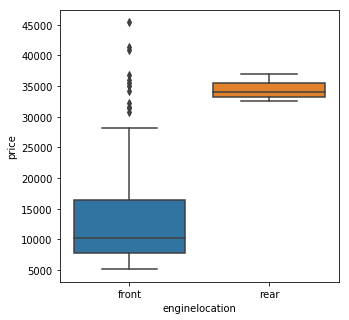

In [1679]:
plt.figure(figsize=(5,5))
sns.boxplot(x='enginelocation',y='price',data=car)

We see rear mounted engines are much costlier than front mounted ones, but front mounted ones are more common.

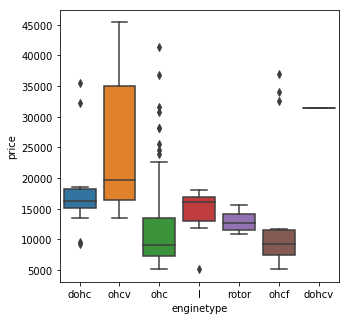

In [1680]:
plt.figure(figsize=(5,5))
sns.boxplot(x='enginetype',y='price',data=car)

We can see thant price increases from ohcf, rotor to l type. Also ohcv displays quite high price.

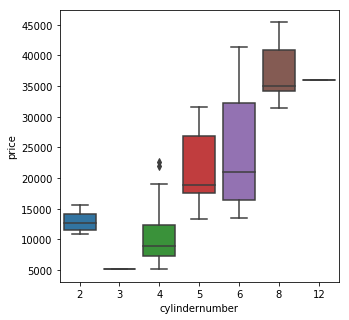

In [1681]:
plt.figure(figsize=(5,5))
sns.boxplot(x='cylindernumber',y='price',data=car)

We see that 2,3,4 cylinder engines are much cheaper than higher cylinder engines. But although this is a categorical variable,we don't create dummy variable as the number here have significance. Instead we convert the words to numeric digits.

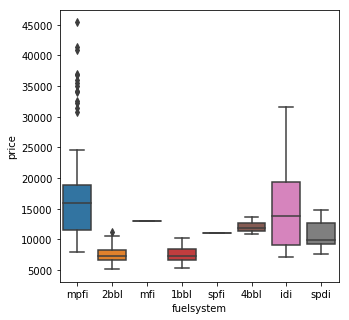

In [1682]:
plt.figure(figsize=(5,5))
sns.boxplot(x='fuelsystem',y='price',data=car)

The 2bbl and 1bbl fuel systems are much cheaper than the others, while mpfi and idi have highest variation in price.

In [1683]:
# creating dummy variables for the categories that are significant.
categories = pd.get_dummies(car[['aspiration','carbody','drivewheel','enginelocation',
                                 'enginetype','fuelsystem']],drop_first=True)

In [1684]:
car = pd.concat([car,categories],axis=1)

In [1685]:
car = car[list(car.select_dtypes(exclude=['object']).columns)]

In [1686]:
car.describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,volume,length:width,city:highway,engine:curb_weight,hp:peakrpm,enginesize:cylnum,enginesize:hp,aspiration_turbo,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginelocation_rear,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,4.380488,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571,618719.288873,2.638502,0.815670,0.049056,0.020399,28.841911,1.266081,0.180488,0.039024,0.341463,0.468293,0.121951,0.585366,0.370732,0.014634,0.004878,0.058537,0.721951,0.073171,0.063415,0.019512,0.321951,0.014634,0.097561,0.004878,0.458537,0.043902,0.004878
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,1.080854,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332,79463.195262,0.123923,0.058449,0.007578,0.007639,5.056321,0.238452,0.385535,0.194127,0.475361,0.500215,0.328031,0.493865,0.484183,0.120377,0.069843,0.235330,0.449134,0.261054,0.244304,0.138655,0.468368,0.120377,0.297446,0.069843,0.499498,0.205380,0.069843
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000,452643.156000,2.262911,0.607143,0.029350,0.009412,19.750000,0.592593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000,566490.600000,2.582298,0.791667,0.045283,0.014583,24.500000,1.131250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000,601385.700000,2.640602,0.812500,0.047925,0.018182,27.500000,1.282353,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,4.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000,666250.200000,2.715505,0.843750,0.051183,0.024167,32.333333,1.405797,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000,846007.659000,2.907895,1.000000,0.082532,0.052400,43.000000,1.964286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [1687]:
# making a copy of car before scaling to use for validation later
car2 = car.copy()

#### Here we are using the standard scaler instead of minmax because some of the variables are highly correlated.

In [1688]:
scaler = StandardScaler()
car[list(car.select_dtypes(exclude=['uint8']).columns)] = scaler.fit_transform(car[list(car.select_dtypes(exclude=['uint8']).columns)])

In [1689]:
y_train = car['price']
x_train = car.drop('price',axis=1)

## Feature Selection

#### Feature selection is done in two steps:
1. Automated selection of the top 20 most significant features using RFE
2. From the above features manually selecting the most important ones based on VIF, adjusted R2 and p-value


In [1690]:
lr = LinearRegression()
lr.fit(x_train,y_train)
selector = RFE(lr,n_features_to_select=20)

In [1691]:
selector = selector.fit(x_train,y_train)

In [1692]:
df = pd.DataFrame({'Column':list(x_train.columns),'Rank':list(selector.ranking_)})

In [1693]:
print('Top 20 Significant features')
print(df.sort_values('Rank').head(20))

Top 20 Significant features
                 Column  Rank
42      fuelsystem_spfi     1
24    carbody_hatchback     1
23      carbody_hardtop     1
28       drivewheel_rwd     1
20    enginesize:cylnum     1
29  enginelocation_rear     1
30     enginetype_dohcv     1
16         length:width     1
15               volume     1
25        carbody_sedan     1
32       enginetype_ohc     1
26        carbody_wagon     1
34      enginetype_ohcv     1
35     enginetype_rotor     1
7            enginesize     1
6        cylindernumber     1
5            curbweight     1
4             carheight     1
37      fuelsystem_4bbl     1
33      enginetype_ohcf     1


In [1694]:
x_train = x_train.loc[:,selector.support_]

In [1695]:
sel_clmn = list(x_train.columns)

In [1696]:
sel_clmn.append('price')

In [1697]:
car_sel = car[sel_clmn]

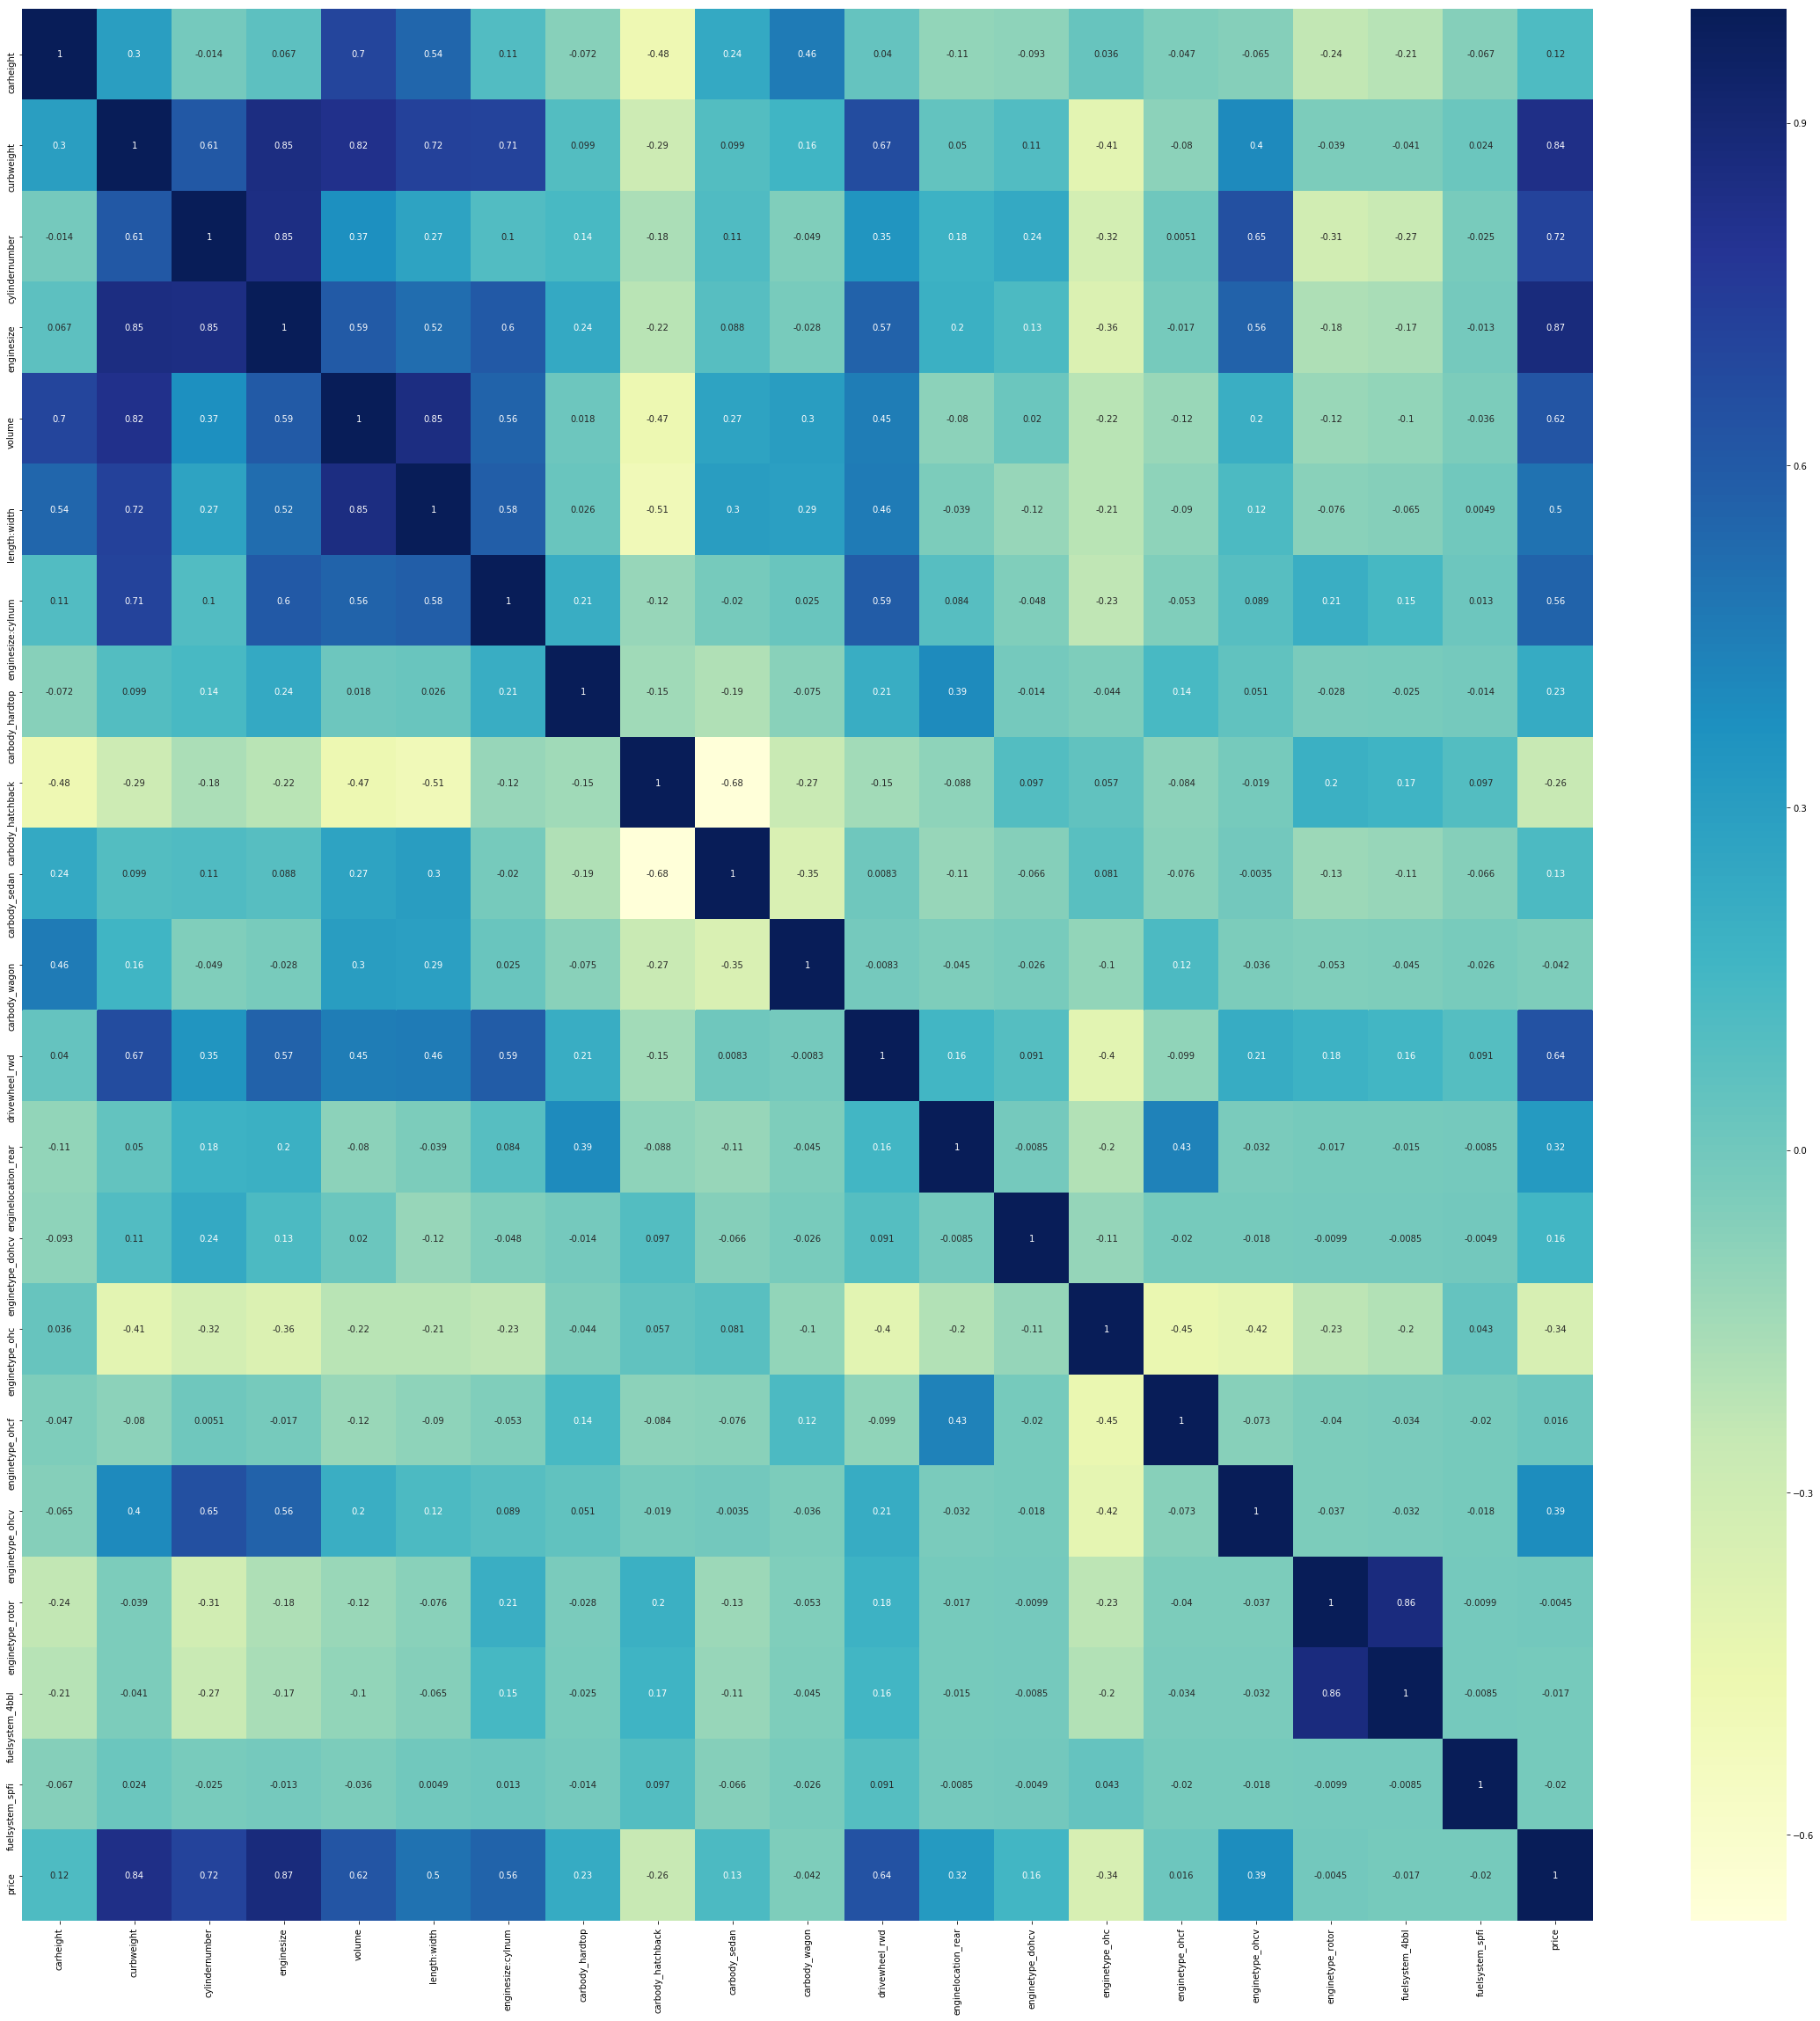

In [1698]:
plt.figure(figsize=(40,40))
sns.heatmap(car_sel.corr(),annot=True,cmap='YlGnBu')

#### Manual feature selection
* We take the forward approach of model building i.e. we start with one variable and iteratively add more variables to reach to our final model.
* Also the entire dataset is considered while selecting features as the size of dataset is very small

The first variable we select is enginesize as it has highest correlation with price .87

In [1699]:
def model(columns):
    x_train_sm = sm.add_constant(x_train[columns])
    lr = sm.OLS(y_train,x_train_sm)
    lr_m = lr.fit()
    print(lr_m.summary())
    return lr_m,x_train_sm

In [1700]:
def get_vif(x_train_sm):
    vif = pd.DataFrame()
    vif['features'] = x_train_sm.columns
    vif['VIF'] = [VIF(x_train_sm.values,i) for i in range(x_train_sm.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values('VIF',ascending=False))

In [1701]:
lr_m,x_train_sm = model(list(x_train.columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     117.3
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           2.02e-93
Time:                        17:40:22   Log-Likelihood:                -22.227
No. Observations:                 205   AIC:                             86.45
Df Residuals:                     184   BIC:                             156.2
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0693    

In [1702]:
get_vif(x_train_sm.drop('const',axis=1))

               features    VIF
3            enginesize  90.22
2        cylindernumber  62.66
6     enginesize:cylnum  33.09
4                volume  16.95
1            curbweight  16.10
14       enginetype_ohc   8.86
9         carbody_sedan   7.04
17     enginetype_rotor   5.39
0             carheight   5.35
5          length:width   5.10
8     carbody_hatchback   4.83
18      fuelsystem_4bbl   4.17
11       drivewheel_rwd   3.56
10        carbody_wagon   3.12
16      enginetype_ohcv   2.67
15      enginetype_ohcf   2.25
7       carbody_hardtop   1.86
12  enginelocation_rear   1.72
13     enginetype_dohcv   1.42
19      fuelsystem_spfi   1.07


# Selecting optimum model
* As the number of variables is very high, we take a forward elimination approach to model selection
* The variable elimination can be done based on considering the VIF, p-value and value of coefficient

* We could see before that enginesize is highly correlated with most other variables and same thing is reflected in VIF
* From heatmap we could see curbweight, enginesize, cylindernumber, compressionratio and horsepower. Each of them has a high correlation with *price* as well.
* We also see that curbweight, enginesize, cylindernumber have very high VFI
* But among them only compressionratio is insignificant.

#### Now there could be two approaches to the first step of elimination:
1. We could eliminate enginesize first as it has highest VIF of 90.22
2. We could eliminate fuelsystem_spfi as it has high p-value of .157

In [1703]:
lr_m,x_train_sm = model(list(x_train.drop(['fuelsystem_spfi'],axis=1).columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     122.7
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           4.87e-94
Time:                        17:40:23   Log-Likelihood:                -23.348
No. Observations:                 205   AIC:                             86.70
Df Residuals:                     185   BIC:                             153.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0893    

In [1704]:
get_vif(x_train_sm.drop('const',axis=1))

               features    VIF
3            enginesize  90.08
2        cylindernumber  62.33
6     enginesize:cylnum  32.85
4                volume  16.87
1            curbweight  15.86
14       enginetype_ohc   8.76
9         carbody_sedan   6.95
17     enginetype_rotor   5.39
0             carheight   5.35
5          length:width   5.06
8     carbody_hatchback   4.83
18      fuelsystem_4bbl   4.17
11       drivewheel_rwd   3.52
10        carbody_wagon   3.09
16      enginetype_ohcv   2.67
15      enginetype_ohcf   2.24
7       carbody_hardtop   1.85
12  enginelocation_rear   1.72
13     enginetype_dohcv   1.42


We see that enginesize, cylindernumber and volume show severe multicolinearity. Now, r2 wise we have a very good model already. But the main objective of the analysis is to predict the KPI variables, so removing multicollinearity and reducing the VFI is very important.
* We have two variables with extreme multicolinearity enginesize and cylindernumber having 0.85 pearson's r. Now these two variables are also highly correlated with price. 
* Engine size has pearson's r of 0.87 and cylinder number 0.72.
* Now we must understand engine size is affected by several parameters like compression ratio (higher compression ratio implies thicker cylinders, hence larger engines), horse power required( more hp generally implies more cylindrr volume), number of cylinders (larger engines required to house more).
* Therefore engine size is a variable derived from many others and hence strongly affects the price.
* Also we see the derived variable enginesize:cylnumber has a lower VIF and a r-value of 0.56

So we drop cylindernumber, as not much information will be lost

In [1705]:
lr_m,x_train_sm = model(list(x_train.drop(['fuelsystem_spfi','cylindernumber'],axis=1).columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     104.9
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           3.67e-87
Time:                        17:40:24   Log-Likelihood:                -43.655
No. Observations:                 205   AIC:                             125.3
Df Residuals:                     186   BIC:                             188.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1748    

In [1706]:
get_vif(x_train_sm.drop('const',axis=1))

               features    VIF
3                volume  16.86
1            curbweight  15.16
13       enginetype_ohc   8.48
2            enginesize   8.43
8         carbody_sedan   6.67
0             carheight   5.24
4          length:width   4.97
16     enginetype_rotor   4.95
7     carbody_hatchback   4.65
17      fuelsystem_4bbl   4.04
5     enginesize:cylnum   3.49
10       drivewheel_rwd   3.48
9         carbody_wagon   3.03
15      enginetype_ohcv   2.59
14      enginetype_ohcf   2.22
6       carbody_hardtop   1.80
11  enginelocation_rear   1.72
12     enginetype_dohcv   1.27


We see that r2 reduces by .016 which is acceptable considering the very high r2 value we have.
* We can see that enginetype_dohcv column has become highy insignificant with p-value of 0.935
* DOHC engines are dual overhead cam-shaft engines. One operated the exhaust and the other the intake valves. These are generally used with cylinders having 4 valves- 2 intake and 2 exhaust.
* For engines having larger number of cylinders (and hence higher speed) at higher speeds time for each cycle becomes very low and hence more number of valves are required.

In [1707]:
lr_m,x_train_sm =  model(list(x_train.drop(['fuelsystem_spfi','cylindernumber','enginetype_dohcv'],axis=1).columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     111.7
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           3.43e-88
Time:                        17:40:24   Log-Likelihood:                -43.659
No. Observations:                 205   AIC:                             123.3
Df Residuals:                     187   BIC:                             183.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1742    

We see no change in r2 or VIF.
* Now we have two variable carheight and fuelsystem_4bbl having p-values of .144 ad .196 respectively.
* carheight has vif of 5.24 and pearson's r 1.2 with price
* fuelsystem_4bbl has VIF of 4.04 and r -.012
* 4bbl or 2bbl are terms referring to carburetors that were used before the eletronic fuel injection systems became popular. 4bbl are more high performaance ( hence slightly more expensive than 2bbl) and 2bbl were widely used.
* If we look into the data mpfi (multi-point fuel injection) is the the highest used.

We can drop both together as they have low effect.

In [1708]:
lr_m,x_train_sm =  model(list(x_train.drop(['fuelsystem_spfi','cylindernumber','enginetype_dohcv',
                                      'fuelsystem_4bbl','carheight'],axis=1).columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           1.72e-89
Time:                        17:40:24   Log-Likelihood:                -45.690
No. Observations:                 205   AIC:                             123.4
Df Residuals:                     189   BIC:                             176.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1710    

In [1709]:
get_vif(x_train_sm.drop('const',axis=1))

               features    VIF
0            curbweight  13.59
11       enginetype_ohc   8.30
1            enginesize   7.82
2                volume   7.01
7         carbody_sedan   6.54
6     carbody_hatchback   4.48
3          length:width   4.42
9        drivewheel_rwd   3.47
4     enginesize:cylnum   3.32
8         carbody_wagon   2.81
13      enginetype_ohcv   2.36
12      enginetype_ohcf   2.20
5       carbody_hardtop   1.79
14     enginetype_rotor   1.70
10  enginelocation_rear   1.68


We see almost no change in R2. Now, only 5 variables have VIF higher than 5.
* Of them curbweight has a vif of 13.59
* Curbweight denotes the weight of the curb without passengers or baggage.
* It depends heavily on volume of car and engine size, thus has a high correlation with price as well
* It is very actionable parameter as per design of car is considered.
* If we look at the other variables present, we have four carbody dummy variables all of which show a negative correlation and have negative coeffincients.
* As our main objective is to explain to business the KPIs, the negative coefficients separately in each of the carbody types will be difficult to justify from design point. From boxplot we could see convertibles are much highly priced than sedan,hatchback or hardtops.

Let us see what is the effect if we drop them.

In [1710]:
lr_m,x_train_sm =  model(list(x_train.drop(['fuelsystem_spfi','cylindernumber','enginetype_dohcv',
                                      'fuelsystem_4bbl','carheight','carbody_sedan','carbody_hatchback',
                                      'carbody_hardtop','carbody_wagon'],axis=1).columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     150.1
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           2.81e-88
Time:                        17:40:25   Log-Likelihood:                -59.506
No. Observations:                 205   AIC:                             143.0
Df Residuals:                     193   BIC:                             182.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3286    

In [1711]:
get_vif(x_train_sm.drop('const',axis=1))

               features    VIF
0            curbweight  12.38
1            enginesize   6.95
2                volume   6.58
3          length:width   3.96
4     enginesize:cylnum   2.95
5        drivewheel_rwd   2.72
9       enginetype_ohcv   1.98
7        enginetype_ohc   1.77
10     enginetype_rotor   1.59
6   enginelocation_rear   1.51
8       enginetype_ohcf   1.29


We see a drop of 0.014 in R2 but still our R2 is very high, indicating almost 89.5 percent of variance being explained.
* The difference between r2 and adjusted r2 reduces.
* Similar to carbody we have engine type dummy variables. Currently we have rotor , ohc (overhead cam)  and ohcv.
* From boxplot, we can see price shows a definite trend as it increases from ohcf, rotor to l.
* From the coefficients we can see rotor engines has a high positive coeff indicating importance, but from heatmap a very low corrleation.

Let us drop ohcf as it has p-value of .197


In [1712]:
lr_m,x_train_sm =  model(list(x_train.drop(['fuelsystem_spfi','cylindernumber','enginetype_dohcv',
                                      'fuelsystem_4bbl','carheight','carbody_sedan','carbody_hatchback',
                                      'carbody_hardtop','carbody_wagon','enginetype_ohcf'],axis=1).columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     164.4
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           4.90e-89
Time:                        17:40:25   Log-Likelihood:                -60.393
No. Observations:                 205   AIC:                             142.8
Df Residuals:                     194   BIC:                             179.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2547    

In [1713]:
get_vif(x_train_sm.drop('const',axis=1))

              features    VIF
0           curbweight  12.36
1           enginesize   6.91
2               volume   6.58
3         length:width   3.96
4    enginesize:cylnum   2.95
5       drivewheel_rwd   2.69
8      enginetype_ohcv   1.98
7       enginetype_ohc   1.75
9     enginetype_rotor   1.58
6  enginelocation_rear   1.24


We can see that now all variables are significant. But the vif of curbweight is 12.36. So we have no way other than removing it.

In [1714]:
lr_m,x_train_sm= model(list(x_train.drop(['fuelsystem_spfi','cylindernumber','enginetype_dohcv',
                                      'fuelsystem_4bbl','carheight','carbody_sedan','carbody_hatchback',
                                      'carbody_hardtop','carbody_wagon','curbweight'],axis=1).columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     152.2
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           3.73e-86
Time:                        17:40:25   Log-Likelihood:                -67.439
No. Observations:                 205   AIC:                             156.9
Df Residuals:                     194   BIC:                             193.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2850    

In [1715]:
get_vif(x_train_sm.drop('const',axis=1))

              features   VIF
0           enginesize  4.47
1               volume  4.31
2         length:width  3.95
3    enginesize:cylnum  2.80
4       drivewheel_rwd  2.28
8      enginetype_ohcv  1.98
9     enginetype_rotor  1.58
6       enginetype_ohc  1.53
5  enginelocation_rear  1.48
7      enginetype_ohcf  1.29


We see now vif is within acceptable value for all variables and r2 only reduced by .007.
* But enginetype_ohcf has become insignificant. As mentioned earlier ohc denotes overhead cam engines. Now my guess is that ohcv and ohcf are differnet configuration of the cam (not sure)


In [1716]:
lr_m, x_train_sm = model(list(x_train.drop(['fuelsystem_spfi','cylindernumber','enginetype_dohcv',
                          'fuelsystem_4bbl','carheight','carbody_sedan','carbody_hatchback',
                          'carbody_hardtop','carbody_wagon','curbweight','enginetype_ohcf'],axis=1).columns))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     169.3
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           3.87e-87
Time:                        17:40:26   Log-Likelihood:                -67.789
No. Observations:                 205   AIC:                             155.6
Df Residuals:                     195   BIC:                             188.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2375    

In [1717]:
get_vif(x_train_sm.drop('const',axis=1))

              features   VIF
0           enginesize  4.40
1               volume  4.31
2         length:width  3.95
3    enginesize:cylnum  2.80
4       drivewheel_rwd  2.26
7      enginetype_ohcv  1.97
8     enginetype_rotor  1.57
6       enginetype_ohc  1.52
5  enginelocation_rear  1.21


We see all variables are significant and VIF is also low enough.

## Discussion on the various statistics
* R2 and adjusted R2 0.887 and 0.881. This implies that we have the perfect number of variables.
* F-statistic is high 169.3 and Prob (F-statistic) is almost zero . This implies that we can reject the null hypothesis and model fit is significant
* Durbin-Watson 1.15. This implies that there is some auto-collinearity.

#### Now we use the car2 dataframe to validate our selected features by building a model with 70:30 train:test split

In [1780]:
sel_col = list(x_train_sm.drop('const',axis=1).columns)
sel_col.append('price')

In [1781]:
car2.head()

,enginesize,volume,length:width,enginesize:cylnum,drivewheel_rwd,enginelocation_rear,enginetype_ohc,enginetype_ohcv,enginetype_rotor,price
0,130,528019.904,2.633385,32.500000,1,0,0,0,0,13495.0
1,130,528019.904,2.633385,32.500000,1,0,0,0,0,16500.0
2,152,587592.640,2.613740,25.333333,1,0,0,1,0,16500.0
3,109,634816.956,2.667674,27.250000,0,0,1,0,0,13950.0
4,136,636734.832,2.659639,27.200000,0,0,1,0,0,17450.0


In [1782]:
train,test = train_test_split(car2[sel_col],train_size=0.7,random_state=100)

In [1783]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 122 to 8
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   enginesize           143 non-null    int64  
 1   volume               143 non-null    float64
 2   length:width         143 non-null    float64
 3   enginesize:cylnum    143 non-null    float64
 4   drivewheel_rwd       143 non-null    uint8  
 5   enginelocation_rear  143 non-null    uint8  
 6   enginetype_ohc       143 non-null    uint8  
 7   enginetype_ohcv      143 non-null    uint8  
 8   enginetype_rotor     143 non-null    uint8  
 9   price                143 non-null    float64
dtypes: float64(4), int64(1), uint8(5)
memory usage: 7.4 KB


In [1784]:
scaler = StandardScaler()
train[list(train.select_dtypes(exclude=['uint8']).columns)] = \
                        scaler.fit_transform(train[list(train.select_dtypes(exclude=['uint8']).columns)])
test[list(test.select_dtypes(exclude=['uint8']).columns)] = \
                        scaler.transform(test[list(test.select_dtypes(exclude=['uint8']).columns)])

In [1785]:
train.head()

,enginesize,volume,length:width,enginesize:cylnum,drivewheel_rwd,enginelocation_rear,enginetype_ohc,enginetype_ohcv,enginetype_rotor,price
122,-0.660242,-0.900714,-0.073870,-0.770844,0,0,1,0,0,-0.700201
125,0.637806,-0.437002,-1.269891,1.910511,1,0,1,0,0,1.151929
166,-0.660242,-0.577707,0.035690,-0.770844,1,0,0,0,0,-0.452248
1,0.123485,-1.079361,0.015251,0.848087,1,0,0,0,0,0.442646
199,0.123485,1.454616,1.425860,0.848087,1,0,1,0,0,0.757569


In [1786]:
y_train = train['price']
x_train = train.drop('price',axis=1)

y_test = test['price']
x_test = test.drop('price',axis=1)

lr = sm.OLS(y_train,x_train)
lr_m = lr.fit()
y_pred = lr_m.predict(x_test)

In [1787]:
print('TEST SET R2: ',r2_score(y_test,y_pred))

TEST SET R2:  0.8970063853743309


We see that the test set R2 is very high .89. But as the test set size is very small we cannot conclude from this the reliability of the model. Therefore we perform bootstrap validation.

## Residual Analysis

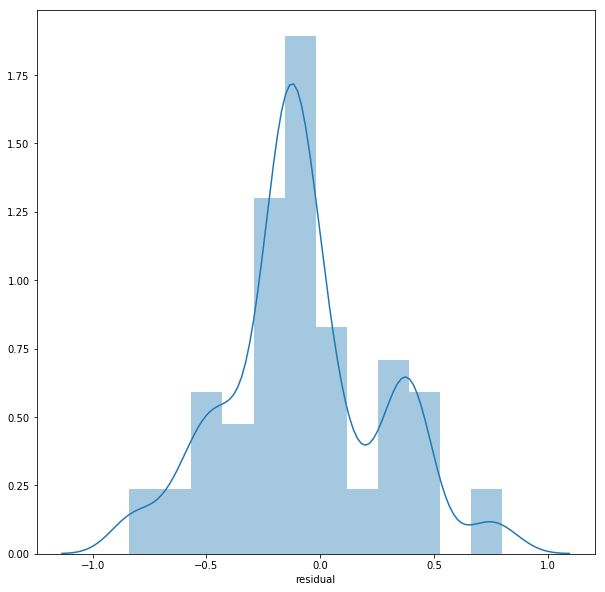

In [1763]:
plt.figure(figsize=(10,10))
plt.xlabel('residual')
sns.distplot(y_test-y_pred)

We can see that the residual is centered at 0.0 mean and matched closely to a normal distribution

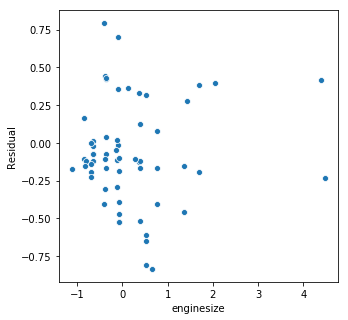

In [1764]:
plt.figure(figsize=(5,5))
plt.ylabel('Residual')
sns.scatterplot(x=x_test['enginesize'],y=y_test-y_pred)

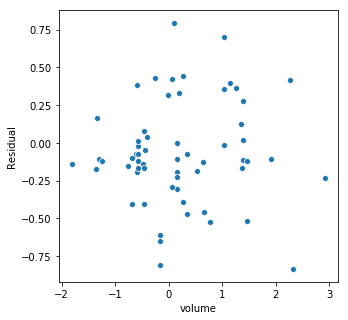

In [1765]:
plt.figure(figsize=(5,5))
plt.ylabel('Residual')
sns.scatterplot(x=x_test['volume'],y=y_test-y_pred)

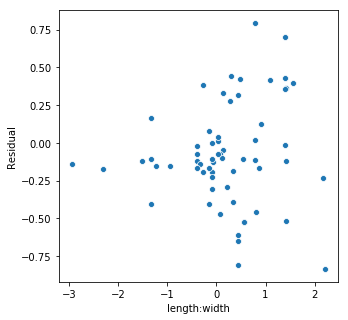

In [1766]:
plt.figure(figsize=(5,5))
plt.ylabel('Residual')
sns.scatterplot(x=x_test['length:width'],y=y_test-y_pred)

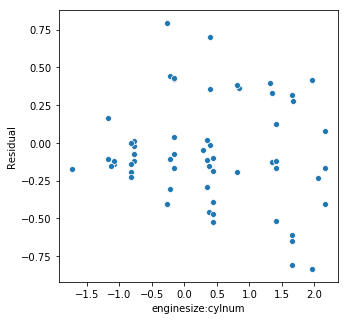

In [1767]:
plt.figure(figsize=(5,5))
plt.ylabel('Residual')
sns.scatterplot(x=x_test['enginesize:cylnum'],y=y_test-y_pred)

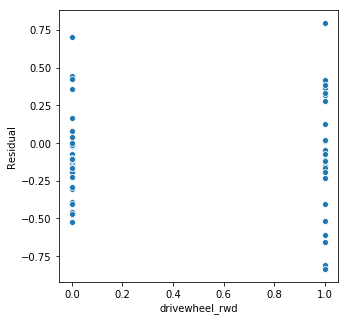

In [1768]:
plt.figure(figsize=(5,5))
plt.ylabel('Residual')
sns.scatterplot(x=x_test['drivewheel_rwd'],y=y_test-y_pred)

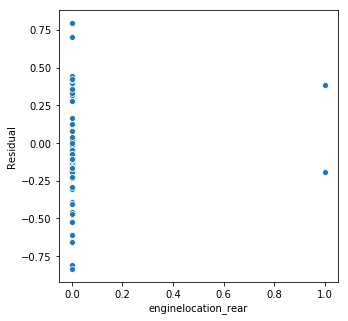

In [1769]:
plt.figure(figsize=(5,5))
plt.ylabel('Residual')
sns.scatterplot(x=x_test['enginelocation_rear'],y=y_test-y_pred)

#### Now our feature selection part is complete and as we have seen from residual analysis no patterns is observable.
#### We have now to show that the selected features can be used to make robust and reproducible results on unseen data

## Confidence Level of R2 through bootstrap validation

### As the dataset is very small the common train-test split will not provide enough evidence of the generallity of the model. So, we do a bootstrap cross-validation taking a train-test split of 70:30

* For each iteration a 70 percent of the data is randomly choosen as the training set.
* The scaler is *fit* only on the training set and the test set is transformed based on the fitted scaler
* Finally we calculate the r2 for each iteration and calculate the confidence interval

In [1770]:
r2_stat = []
rmse_stat = []
res_var_stat = []
score_stat = []
n_iterations =1000
n_size = int(len(car)*0.7)
sel_col = list(x_train_sm.drop('const',axis=1).columns)
sel_col.append('price')
car2 = car2[sel_col]
for i in range(n_iterations):
    train_ind = list(np.random.randint(0,len(car2),n_size))
    test_ind = set(range(len(car2))).difference(set(train_ind))
    scaler = StandardScaler()
    train = car2.loc[train_ind,:]
    test = car2.loc[test_ind,:]
    train[list(train.select_dtypes(exclude=['uint8']).columns)] = \
                            scaler.fit_transform(train[list(train.select_dtypes(exclude=['uint8']).columns)])
    test[list(test.select_dtypes(exclude=['uint8']).columns)] = \
                            scaler.transform(test[list(test.select_dtypes(exclude=['uint8']).columns)])
    y_train = train['price']
    x_train = train.drop('price',axis=1)
    
    y_test = test['price']
    x_test = test.drop('price',axis=1)
    
    lr = sm.OLS(y_train,x_train)
    lr_m = lr.fit()
    y_pred = lr_m.predict(x_test)
    
    r2 = r2_score(y_test,y_pred)    # the r2_score calculation
    
    r2_stat.append(r2)
    mse = mean_squared_error(y_test,y_pred)
    rmse_stat.append(round(np.sqrt(mse),2))
    residual = y_test - y_pred
    res_var_stat.append(round(np.std(residual),2))

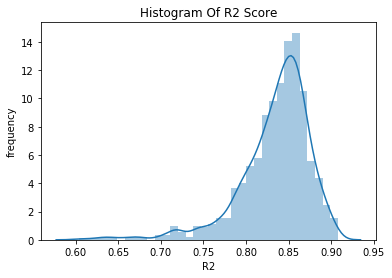

In [1771]:
plt.figure()
plt.title('Histogram Of R2 Score')
plt.xlabel('R2')
plt.ylabel('frequency')
sns.distplot(r2_stat)

In [1772]:
def get_confidence_level(alpha,stat,name):
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stat, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stat, p))
    print(f'%.1f confidence interval for {name} %.2f and %.2f' % (alpha*100, lower, upper))

In [1773]:
get_confidence_level(0.99,r2_stat,'r2')
get_confidence_level(0.95,r2_stat,'r2')
get_confidence_level(0.68,r2_stat,'r2')
print('mean R2: ',round(np.mean(r2_stat),2),' std R2: ',round(np.std(r2_stat),2))


99.0 confidence interval for r2 0.64 and 0.90
95.0 confidence interval for r2 0.72 and 0.89
68.0 confidence interval for r2 0.80 and 0.87
mean R2:  0.83  std R2:  0.04


We see the selected columns give a 99% confidence level of the r2 value being between .63 and .90.

In itself to be able to explain 63% variability is good enough.

So we can conclude the columns selected for our model are the KPIs.

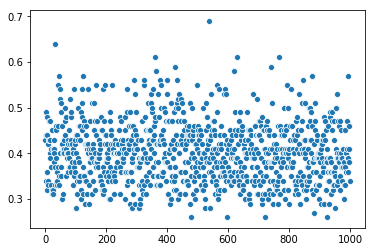

In [1776]:
res_var = pd.Series(res_var_stat)
sns.scatterplot(data=res_var)

# Business Relevance of the Selected Columns

From our analysis we have found the 
0.           enginesize
1.               volume
2.         length:width
3.    enginesize:cylnum
4.       drivewheel_rwd
5.      enginetype_ohcv
6.     enginetype_rotor
7.      enginetype_ohc
8.  enginelocation_rear

Let us now understand what some of thess variables may mean to the business:
* Enginesize: we saw with enignesize price of car increases. This is because a higher enginesize inherently means more number of cylinders, sturdier chasis and hence a faster car. So, a smaller engine size will always translate to a lesser cost.
* Volume : This is very easy to understand, as hatchbacks are smaller than convertibles in terms of length. Generally (not always) a higher volume car costs more.
* enginelocation_rear and drivewheel_rwd : This two variables indicate more price due to same fundamental reason : advantages provided by the rear wheeel or rear mounted engine. All rear mounted engine cars are autommatically rear wheel driven. This provides better handling at higher speeds due to improved weight distribution. As a result most sports cars use this configuration. And as they are expensive inherently the price increases for this category.
* enginetype_rotor : As indicated by the coeff it has a high  significance. The two main reasons are as follows: 
                    1. Almost no companies use rotary engines now except for manufacturers like Mazda
                    2. The rotary engines are high emission engines and have are hard to maintain, leading to higher sanctions.